In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings(action='ignore')
from epftoolbox.evaluation import MAE, sMAPE

C:\Users\UX431\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# LEAR

In [2]:
df = pd.read_csv(r"Data/df_alemania_final.csv")

In [3]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [4]:
df = df.fillna(0)

In [5]:
df.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Simple Date    0
Hour           0
dtype: int64

In [6]:
df

,Date,Price,Exogenous 1,Exogenous 2,Exogenous 3,Simple Date,Hour
0,2019-01-01 00:00:00,28.32,44216.0,0.0,23266.0,2019-01-01,0
1,2019-01-01 01:00:00,10.07,42397.0,0.0,25111.0,2019-01-01,1
2,2019-01-01 02:00:00,-4.08,40788.0,0.0,26717.0,2019-01-01,2
3,2019-01-01 03:00:00,-9.91,40307.0,0.0,28512.0,2019-01-01,3
4,2019-01-01 04:00:00,-7.41,40479.0,0.0,29911.0,2019-01-01,4
...,...,...,...,...,...,...,...
38683,2023-05-31 19:00:00,108.26,57968.0,7000.0,13056.0,2023-05-31,19
38684,2023-05-31 20:00:00,119.60,56582.0,2149.0,13078.0,2023-05-31,20
38685,2023-05-31 21:00:00,103.69,54087.0,276.0,14354.0,2023-05-31,21
38686,2023-05-31 22:00:00,94.28,51883.0,0.0,16051.0,2023-05-31,22


In [7]:
df['Exogenous 2'] = df['Exogenous 2'] + df['Exogenous 3']
df = df.drop(['Exogenous 3'], axis = 1)

In [8]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [9]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2019-01-01 00:00:00,28.32,44216.0,23266.0,2019-01-01,0
1,2019-01-01 01:00:00,10.07,42397.0,25111.0,2019-01-01,1
2,2019-01-01 02:00:00,-4.08,40788.0,26717.0,2019-01-01,2
3,2019-01-01 03:00:00,-9.91,40307.0,28512.0,2019-01-01,3
4,2019-01-01 04:00:00,-7.41,40479.0,29911.0,2019-01-01,4
...,...,...,...,...,...,...
38683,2023-05-31 19:00:00,108.26,57968.0,20056.0,2023-05-31,19
38684,2023-05-31 20:00:00,119.60,56582.0,15227.0,2023-05-31,20
38685,2023-05-31 21:00:00,103.69,54087.0,14630.0,2023-05-31,21
38686,2023-05-31 22:00:00,94.28,51883.0,16051.0,2023-05-31,22


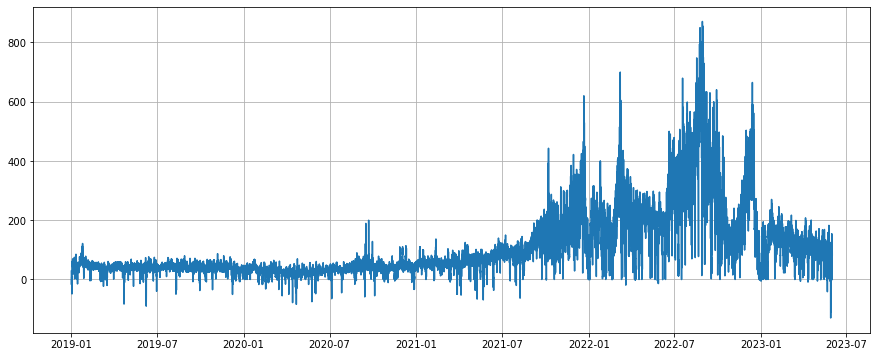

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

In [11]:
df['Price_no_outliers'] = df.Price

Se añaden variables auxiliares

In [12]:
df['Price_24'] = df.Price.shift(24)
df['Price_48'] = df.Price.shift(48)
df['Price_72'] = df.Price.shift(72)
df['Price_96'] = df.Price.shift(96)
df['Price_120'] = df.Price.shift(120)
df['Price_144'] = df.Price.shift(144)
df['Price_168'] = df.Price.shift(168)

In [13]:
df["diff_Price_24"] = df.Price - df.Price_24
df["lower_quantile_diff_Price_24"] = np.nan
df["upper_quantile_diff_Price_24"] = np.nan
for idx in range(len(df)):
    if idx >= 168:
        df_aux = df.loc[idx - 168 : idx - 1]
        df.loc[idx, "lower_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.025
        )
        df.loc[idx, "upper_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.975
        )

df["outlier"] = 0
df.loc[
    (df.diff_Price_24 < df.lower_quantile_diff_Price_24)
    | (df.diff_Price_24 > df.upper_quantile_diff_Price_24),
    "outlier",
] = 1

# df["Price_no_outliers"] = df["Price"]
col = df.loc[
    :,
    [
        "Price_24",
        "Price_48",
        "Price_72",
        "Price_96",
        "Price_120",
        "Price_144",
        "Price_168",
    ],
]
df["Price_median"] = col.median(axis=1)
df.loc[df.outlier == 1, "Price_no_outliers"] = df[
    df.outlier == 1
].Price_median

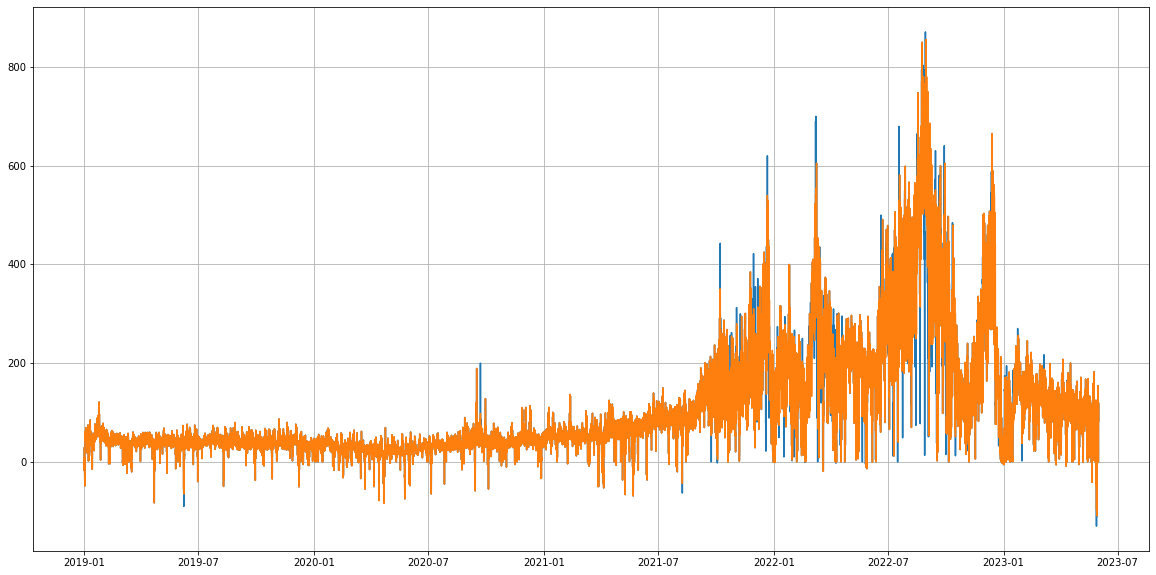

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(df.Date, df.Price)
ax.plot(df.Date, df.Price_no_outliers)
ax.grid()

In [15]:
df = df[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']].rename(columns={'Price_no_outliers':'Price'})

In [16]:
df.index = df.Date

In [17]:
df = df.drop(['Date'], axis = 1)

In [18]:
df_train = df[df.index < dt.datetime(2022, 1, 1)]
df_test = df[df.index >= dt.datetime(2022, 1, 1)]

In [19]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [20]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [21]:
forecast_dates = forecast.index

In [22]:
from epftoolbox.models import LEAR

In [23]:
calibration_window = 2*364

In [24]:
model = LEAR(calibration_window=calibration_window)

In [25]:
df_original = pd.read_csv(r"Data\df_alemania_final.csv")

In [26]:
df_original['Date'] = pd.to_datetime(df_original.Date)
df_original['Simple Date'] = df_original.Date.dt.strftime("%Y-%m-%d")
df_original['Hour'] = df_original.Date.dt.hour

In [27]:
df_original = df_original.fillna(0)

In [28]:
df_original.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Simple Date    0
Hour           0
dtype: int64

In [29]:
df_original

,Date,Price,Exogenous 1,Exogenous 2,Exogenous 3,Simple Date,Hour
0,2019-01-01 00:00:00,28.32,44216.0,0.0,23266.0,2019-01-01,0
1,2019-01-01 01:00:00,10.07,42397.0,0.0,25111.0,2019-01-01,1
2,2019-01-01 02:00:00,-4.08,40788.0,0.0,26717.0,2019-01-01,2
3,2019-01-01 03:00:00,-9.91,40307.0,0.0,28512.0,2019-01-01,3
4,2019-01-01 04:00:00,-7.41,40479.0,0.0,29911.0,2019-01-01,4
...,...,...,...,...,...,...,...
38683,2023-05-31 19:00:00,108.26,57968.0,7000.0,13056.0,2023-05-31,19
38684,2023-05-31 20:00:00,119.60,56582.0,2149.0,13078.0,2023-05-31,20
38685,2023-05-31 21:00:00,103.69,54087.0,276.0,14354.0,2023-05-31,21
38686,2023-05-31 22:00:00,94.28,51883.0,0.0,16051.0,2023-05-31,22


In [30]:
df_original['Exogenous 2'] = df_original['Exogenous 2'] + df_original['Exogenous 3']
df_original = df_original.drop(['Exogenous 3'], axis = 1)

In [31]:
df_original.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [32]:
df_original.index = df_original.Date

In [33]:
df_original = df_original.drop('Date', axis = 1)

In [34]:
df_original = df_original.drop(['Simple Date', 'Hour'], axis = 1)

In [35]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [36]:
df_original = df_original[df_original.index >= dt.datetime(2022, 1, 1)]

In [37]:
real_values = df_original[df_original.index >= dt.datetime(2022, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [38]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,50.05,41.33,43.22,45.46,37.67,39.70,40.59,43.26,49.66,70.05,...,97.17,101.00,126.60,149.97,146.33,140.28,121.88,102.61,97.46,85.16
2022-01-02,57.08,52.59,48.97,34.94,29.56,33.97,34.52,41.80,48.95,60.01,...,40.01,29.11,32.76,42.97,60.96,60.94,54.12,46.16,46.29,32.93
2022-01-03,0.31,-0.01,-0.07,-1.05,-1.00,0.32,37.55,88.76,122.93,110.17,...,80.99,98.05,123.51,148.49,138.00,117.64,117.71,95.95,105.68,95.26
2022-01-04,103.70,108.27,105.92,103.41,102.71,114.23,156.91,182.64,178.91,190.00,...,179.00,180.93,166.69,189.88,184.94,178.99,156.12,140.92,137.92,97.56
2022-01-05,105.31,97.29,84.50,75.38,79.11,94.79,99.16,101.15,129.56,113.37,...,107.32,119.48,137.28,148.09,139.88,135.75,119.93,98.09,118.71,99.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,89.69,83.53,84.73,86.33,91.25,90.00,82.70,82.99,72.61,55.06,...,-2.39,0.51,2.26,55.08,84.85,100.38,124.93,113.08,100.03,94.71
2023-05-28,87.09,84.00,81.92,77.87,77.86,76.47,72.02,64.84,37.70,0.00,...,-129.96,-98.08,-18.68,-0.06,50.00,72.90,80.01,77.84,73.80,69.50
2023-05-29,59.23,53.90,51.82,48.51,54.52,63.36,67.65,58.71,29.92,0.00,...,-109.45,-80.69,-19.97,-4.98,19.20,72.08,83.75,85.88,80.48,74.26


In [39]:
forecast_dates = forecast.index

In [40]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 104.71%  |  MAE: 50.619
2022-01-02 - sMAPE: 83.20%  |  MAE: 46.349
2022-01-03 - sMAPE: 82.46%  |  MAE: 41.962
2022-01-04 - sMAPE: 68.02%  |  MAE: 39.648
2022-01-05 - sMAPE: 58.93%  |  MAE: 36.995
2022-01-06 - sMAPE: 52.86%  |  MAE: 36.884
2022-01-07 - sMAPE: 51.13%  |  MAE: 40.185
2022-01-08 - sMAPE: 48.48%  |  MAE: 40.862
2022-01-09 - sMAPE: 45.12%  |  MAE: 38.973
2022-01-10 - sMAPE: 43.09%  |  MAE: 40.310
2022-01-11 - sMAPE: 41.19%  |  MAE: 41.275
2022-01-12 - sMAPE: 38.67%  |  MAE: 39.861
2022-01-13 - sMAPE: 36.34%  |  MAE: 37.866
2022-01-14 - sMAPE: 34.27%  |  MAE: 36.202
2022-01-15 - sMAPE: 32.47%  |  MAE: 34.752
2022-01-16 - sMAPE: 31.80%  |  MAE: 34.480
2022-01-17 - sMAPE: 33.60%  |  MAE: 36.978
2022-01-18 - sMAPE: 32.92%  |  MAE: 38.233
2022-01-19 - sMAPE: 31.75%  |  MAE: 37.164
2022-01-20 - sMAPE: 31.05%  |  MAE: 36.390
2022-01-21 - sMAPE: 30.37%  |  MAE: 35.925
2022-01-22 - sMAPE: 29.23%  |  MAE: 34.693
2022-01-23 - sMAPE: 28.36%  |  MAE: 33.920
2022-01-24

2022-07-11 - sMAPE: 27.71%  |  MAE: 37.359
2022-07-12 - sMAPE: 27.65%  |  MAE: 37.427
2022-07-13 - sMAPE: 27.59%  |  MAE: 37.503
2022-07-14 - sMAPE: 27.54%  |  MAE: 37.585
2022-07-15 - sMAPE: 27.46%  |  MAE: 37.565
2022-07-16 - sMAPE: 27.74%  |  MAE: 37.932
2022-07-17 - sMAPE: 27.72%  |  MAE: 37.960
2022-07-18 - sMAPE: 27.68%  |  MAE: 38.095
2022-07-19 - sMAPE: 27.61%  |  MAE: 38.170
2022-07-20 - sMAPE: 27.55%  |  MAE: 38.241
2022-07-21 - sMAPE: 27.45%  |  MAE: 38.180
2022-07-22 - sMAPE: 27.39%  |  MAE: 38.310
2022-07-23 - sMAPE: 27.32%  |  MAE: 38.346
2022-07-24 - sMAPE: 27.37%  |  MAE: 38.540
2022-07-25 - sMAPE: 27.29%  |  MAE: 38.501
2022-07-26 - sMAPE: 27.23%  |  MAE: 38.534
2022-07-27 - sMAPE: 27.19%  |  MAE: 38.686
2022-07-28 - sMAPE: 27.15%  |  MAE: 38.867
2022-07-29 - sMAPE: 27.04%  |  MAE: 38.791
2022-07-30 - sMAPE: 26.96%  |  MAE: 38.772
2022-07-31 - sMAPE: 26.89%  |  MAE: 38.784
2022-08-01 - sMAPE: 26.81%  |  MAE: 38.770
2022-08-02 - sMAPE: 26.70%  |  MAE: 38.652
2022-08-03 

2023-01-18 - sMAPE: 27.01%  |  MAE: 40.715
2023-01-19 - sMAPE: 26.96%  |  MAE: 40.641
2023-01-20 - sMAPE: 26.91%  |  MAE: 40.571
2023-01-21 - sMAPE: 26.86%  |  MAE: 40.492
2023-01-22 - sMAPE: 26.82%  |  MAE: 40.434
2023-01-23 - sMAPE: 26.78%  |  MAE: 40.379
2023-01-24 - sMAPE: 26.72%  |  MAE: 40.299
2023-01-25 - sMAPE: 26.67%  |  MAE: 40.244
2023-01-26 - sMAPE: 26.64%  |  MAE: 40.196
2023-01-27 - sMAPE: 26.58%  |  MAE: 40.118
2023-01-28 - sMAPE: 26.54%  |  MAE: 40.049
2023-01-29 - sMAPE: 26.50%  |  MAE: 39.991
2023-01-30 - sMAPE: 26.54%  |  MAE: 39.940
2023-01-31 - sMAPE: 26.53%  |  MAE: 39.899
2023-02-01 - sMAPE: 26.49%  |  MAE: 39.825
2023-02-02 - sMAPE: 26.45%  |  MAE: 39.767
2023-02-03 - sMAPE: 26.42%  |  MAE: 39.707
2023-02-04 - sMAPE: 26.39%  |  MAE: 39.657
2023-02-05 - sMAPE: 26.35%  |  MAE: 39.591
2023-02-06 - sMAPE: 26.30%  |  MAE: 39.513
2023-02-07 - sMAPE: 26.26%  |  MAE: 39.453
2023-02-08 - sMAPE: 26.21%  |  MAE: 39.392
2023-02-09 - sMAPE: 26.18%  |  MAE: 39.341
2023-02-10 

In [41]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,2.532683,-3.741827,-5.641436,-12.875345,-9.205302,3.213013,7.677207,13.833762,33.179132,43.304168,...,44.625516,45.971062,59.47491,70.981593,63.897971,60.737259,45.193134,40.031463,43.019067,36.586095
2022-01-02,81.895477,73.50371,65.329845,59.728637,59.365541,70.259553,77.747657,104.541705,104.600975,118.396708,...,105.752635,101.459683,94.266744,112.001742,107.387227,102.351135,84.838087,73.139157,73.646508,62.673103
2022-01-03,28.886156,27.646116,24.162303,21.492467,20.474572,32.810147,47.309326,65.091596,97.053617,72.418355,...,54.722888,57.520066,71.745896,89.918189,89.187551,80.736204,68.154759,55.143191,53.387909,45.795672
2022-01-04,96.560248,82.920344,82.832702,71.844098,76.250773,90.822661,106.693363,139.732598,165.87542,151.763026,...,141.8801,133.836111,145.318031,179.300457,157.161427,140.772111,116.697769,98.288957,93.133038,70.04158
2022-01-05,87.958535,85.209605,74.356828,68.152179,64.112311,70.246891,73.880426,117.112475,146.09759,146.857995,...,186.884534,162.895925,152.597804,185.411192,157.777342,143.104658,128.115462,107.868127,98.179319,77.846303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,93.455978,83.886455,81.821011,79.572917,81.315237,80.555747,87.058706,86.270789,75.766762,58.601586,...,1.712184,18.232455,24.635942,54.097018,85.129519,122.08958,131.50268,133.337001,120.228607,116.128411
2023-05-28,95.952218,85.115941,81.898102,79.492123,76.18344,72.453681,57.51894,43.961462,26.797149,16.677305,...,-57.335296,-56.755936,-25.751642,10.149592,48.01195,74.950694,97.395237,93.454011,86.988052,77.700735
2023-05-29,60.814088,53.092866,50.818408,50.091152,48.167167,53.839066,49.518269,42.281538,21.61646,6.863033,...,-45.765262,-40.16483,-18.367498,-2.138405,30.015354,57.89361,76.264298,78.942296,73.472124,63.678509


In [42]:
forecast.to_csv("Resultados/alemania_final_2_anos_ventana_no_outliers.csv")

In [43]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [44]:
forecast_dates = forecast.index

In [45]:
calibration_window = 1*364

In [46]:
model = LEAR(calibration_window=calibration_window)

In [47]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 98.43%  |  MAE: 44.561
2022-01-02 - sMAPE: 82.39%  |  MAE: 45.490
2022-01-03 - sMAPE: 79.95%  |  MAE: 39.821
2022-01-04 - sMAPE: 66.97%  |  MAE: 39.513
2022-01-05 - sMAPE: 56.63%  |  MAE: 34.870
2022-01-06 - sMAPE: 52.64%  |  MAE: 38.076
2022-01-07 - sMAPE: 49.91%  |  MAE: 39.908
2022-01-08 - sMAPE: 47.19%  |  MAE: 40.242
2022-01-09 - sMAPE: 44.96%  |  MAE: 40.017
2022-01-10 - sMAPE: 44.10%  |  MAE: 43.399
2022-01-11 - sMAPE: 41.51%  |  MAE: 42.821
2022-01-12 - sMAPE: 39.13%  |  MAE: 41.808
2022-01-13 - sMAPE: 36.97%  |  MAE: 40.053
2022-01-14 - sMAPE: 34.87%  |  MAE: 38.181
2022-01-15 - sMAPE: 33.23%  |  MAE: 37.002
2022-01-16 - sMAPE: 32.90%  |  MAE: 37.184
2022-01-17 - sMAPE: 34.66%  |  MAE: 39.591
2022-01-18 - sMAPE: 33.65%  |  MAE: 40.027
2022-01-19 - sMAPE: 32.58%  |  MAE: 39.171
2022-01-20 - sMAPE: 31.72%  |  MAE: 38.123
2022-01-21 - sMAPE: 31.08%  |  MAE: 37.672
2022-01-22 - sMAPE: 30.17%  |  MAE: 36.809
2022-01-23 - sMAPE: 29.24%  |  MAE: 35.909
2022-01-24 

2022-07-11 - sMAPE: 28.08%  |  MAE: 38.139
2022-07-12 - sMAPE: 28.01%  |  MAE: 38.186
2022-07-13 - sMAPE: 27.94%  |  MAE: 38.222
2022-07-14 - sMAPE: 27.88%  |  MAE: 38.306
2022-07-15 - sMAPE: 27.77%  |  MAE: 38.215
2022-07-16 - sMAPE: 28.05%  |  MAE: 38.569
2022-07-17 - sMAPE: 28.08%  |  MAE: 38.692
2022-07-18 - sMAPE: 28.06%  |  MAE: 38.888
2022-07-19 - sMAPE: 27.99%  |  MAE: 38.962
2022-07-20 - sMAPE: 27.92%  |  MAE: 39.004
2022-07-21 - sMAPE: 27.85%  |  MAE: 39.034
2022-07-22 - sMAPE: 27.76%  |  MAE: 39.050
2022-07-23 - sMAPE: 27.67%  |  MAE: 39.014
2022-07-24 - sMAPE: 27.71%  |  MAE: 39.137
2022-07-25 - sMAPE: 27.61%  |  MAE: 39.065
2022-07-26 - sMAPE: 27.55%  |  MAE: 39.091
2022-07-27 - sMAPE: 27.53%  |  MAE: 39.309
2022-07-28 - sMAPE: 27.50%  |  MAE: 39.545
2022-07-29 - sMAPE: 27.40%  |  MAE: 39.500
2022-07-30 - sMAPE: 27.30%  |  MAE: 39.409
2022-07-31 - sMAPE: 27.22%  |  MAE: 39.391
2022-08-01 - sMAPE: 27.16%  |  MAE: 39.423
2022-08-02 - sMAPE: 27.05%  |  MAE: 39.310
2022-08-03 

2023-01-18 - sMAPE: 27.31%  |  MAE: 41.476
2023-01-19 - sMAPE: 27.27%  |  MAE: 41.407
2023-01-20 - sMAPE: 27.22%  |  MAE: 41.339
2023-01-21 - sMAPE: 27.19%  |  MAE: 41.293
2023-01-22 - sMAPE: 27.15%  |  MAE: 41.230
2023-01-23 - sMAPE: 27.10%  |  MAE: 41.161
2023-01-24 - sMAPE: 27.05%  |  MAE: 41.115
2023-01-25 - sMAPE: 27.03%  |  MAE: 41.098
2023-01-26 - sMAPE: 27.01%  |  MAE: 41.089
2023-01-27 - sMAPE: 26.97%  |  MAE: 41.037
2023-01-28 - sMAPE: 26.94%  |  MAE: 41.000
2023-01-29 - sMAPE: 26.94%  |  MAE: 40.959
2023-01-30 - sMAPE: 26.98%  |  MAE: 40.905
2023-01-31 - sMAPE: 26.98%  |  MAE: 40.867
2023-02-01 - sMAPE: 26.94%  |  MAE: 40.796
2023-02-02 - sMAPE: 26.91%  |  MAE: 40.728
2023-02-03 - sMAPE: 26.88%  |  MAE: 40.672
2023-02-04 - sMAPE: 26.84%  |  MAE: 40.601
2023-02-05 - sMAPE: 26.79%  |  MAE: 40.532
2023-02-06 - sMAPE: 26.75%  |  MAE: 40.477
2023-02-07 - sMAPE: 26.73%  |  MAE: 40.450
2023-02-08 - sMAPE: 26.70%  |  MAE: 40.411
2023-02-09 - sMAPE: 26.67%  |  MAE: 40.361
2023-02-10 

In [48]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,-4.242313,-12.323147,-6.141374,-1.32917,-4.318574,6.354119,-17.313065,-1.908064,39.461658,55.14434,...,63.062093,62.649149,65.386433,77.554846,82.220344,71.824331,27.99083,41.774585,63.948322,50.996701
2022-01-02,81.702041,79.78018,73.232897,70.354344,72.900225,73.550531,91.076992,117.34831,118.79806,113.532066,...,75.925879,76.842873,84.104822,121.691318,124.902712,128.343728,107.035705,93.080399,93.173294,83.194613
2022-01-03,22.961844,32.598901,26.511947,15.601105,20.284825,43.42628,81.009093,83.525598,118.552848,77.003163,...,50.788551,54.208353,74.410438,93.133553,102.309757,97.919287,84.176851,70.232534,67.466125,55.090378
2022-01-04,97.198774,86.719534,88.468293,79.901415,81.546528,90.911021,99.326173,125.401418,146.950877,133.482052,...,114.338352,120.904338,135.825602,162.846428,157.14564,151.636182,137.577517,113.859283,98.555588,82.010875
2022-01-05,84.094518,78.3484,71.863514,70.148771,69.536996,75.399296,65.580306,100.269782,149.625105,128.074063,...,129.317724,139.399376,157.483921,182.457668,152.357763,137.602298,128.375462,112.981011,110.940287,87.653493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,94.622013,87.890448,86.579146,86.292315,85.499811,79.089687,78.566683,75.543469,59.663171,49.249017,...,-1.022505,14.004043,29.660083,63.55259,97.893712,125.830113,134.309127,136.09218,128.749752,124.53053
2023-05-28,99.585203,92.237753,91.648727,86.830656,82.986906,71.225165,48.703116,44.103614,42.602667,15.363911,...,-31.784763,-12.853962,-3.059829,37.130822,73.162368,81.576052,100.356587,101.978513,97.848642,92.314479
2023-05-29,75.30472,66.941316,62.439901,59.513612,57.392227,50.799129,42.577595,33.969523,20.982025,-5.311219,...,-42.103004,-24.040741,-24.584072,5.084965,46.022669,54.432959,86.01484,88.389313,82.082619,75.846638


In [49]:
forecast.to_csv("Resultados/alemania_final_1_ano_ventana_no_outliers.csv")

In [50]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [51]:
forecast_dates = forecast.index

In [52]:
calibration_window = 182

In [53]:
model = LEAR(calibration_window=calibration_window)

In [54]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 68.86%  |  MAE: 31.849
2022-01-02 - sMAPE: 63.91%  |  MAE: 35.835
2022-01-03 - sMAPE: 66.53%  |  MAE: 31.424
2022-01-04 - sMAPE: 54.99%  |  MAE: 30.378
2022-01-05 - sMAPE: 49.13%  |  MAE: 30.578
2022-01-06 - sMAPE: 45.30%  |  MAE: 32.996
2022-01-07 - sMAPE: 42.92%  |  MAE: 34.968
2022-01-08 - sMAPE: 40.29%  |  MAE: 34.872
2022-01-09 - sMAPE: 38.68%  |  MAE: 34.795
2022-01-10 - sMAPE: 38.46%  |  MAE: 39.088
2022-01-11 - sMAPE: 35.93%  |  MAE: 37.740
2022-01-12 - sMAPE: 33.95%  |  MAE: 37.004
2022-01-13 - sMAPE: 32.55%  |  MAE: 36.601
2022-01-14 - sMAPE: 30.84%  |  MAE: 35.158
2022-01-15 - sMAPE: 29.39%  |  MAE: 34.001
2022-01-16 - sMAPE: 29.64%  |  MAE: 34.997
2022-01-17 - sMAPE: 31.61%  |  MAE: 37.596
2022-01-18 - sMAPE: 30.44%  |  MAE: 36.882
2022-01-19 - sMAPE: 29.80%  |  MAE: 36.736
2022-01-20 - sMAPE: 29.47%  |  MAE: 36.374
2022-01-21 - sMAPE: 28.84%  |  MAE: 35.874
2022-01-22 - sMAPE: 27.90%  |  MAE: 34.862
2022-01-23 - sMAPE: 27.15%  |  MAE: 34.222
2022-01-24 

2022-07-11 - sMAPE: 27.64%  |  MAE: 37.834
2022-07-12 - sMAPE: 27.58%  |  MAE: 37.893
2022-07-13 - sMAPE: 27.53%  |  MAE: 37.987
2022-07-14 - sMAPE: 27.51%  |  MAE: 38.158
2022-07-15 - sMAPE: 27.41%  |  MAE: 38.113
2022-07-16 - sMAPE: 27.69%  |  MAE: 38.477
2022-07-17 - sMAPE: 27.71%  |  MAE: 38.578
2022-07-18 - sMAPE: 27.69%  |  MAE: 38.785
2022-07-19 - sMAPE: 27.63%  |  MAE: 38.876
2022-07-20 - sMAPE: 27.57%  |  MAE: 38.932
2022-07-21 - sMAPE: 27.50%  |  MAE: 38.989
2022-07-22 - sMAPE: 27.42%  |  MAE: 39.044
2022-07-23 - sMAPE: 27.35%  |  MAE: 39.039
2022-07-24 - sMAPE: 27.39%  |  MAE: 39.172
2022-07-25 - sMAPE: 27.28%  |  MAE: 39.063
2022-07-26 - sMAPE: 27.22%  |  MAE: 39.086
2022-07-27 - sMAPE: 27.21%  |  MAE: 39.331
2022-07-28 - sMAPE: 27.20%  |  MAE: 39.636
2022-07-29 - sMAPE: 27.11%  |  MAE: 39.643
2022-07-30 - sMAPE: 27.02%  |  MAE: 39.574
2022-07-31 - sMAPE: 26.95%  |  MAE: 39.568
2022-08-01 - sMAPE: 26.88%  |  MAE: 39.616
2022-08-02 - sMAPE: 26.79%  |  MAE: 39.546
2022-08-03 

2023-01-18 - sMAPE: 29.09%  |  MAE: 44.056
2023-01-19 - sMAPE: 29.05%  |  MAE: 43.993
2023-01-20 - sMAPE: 29.00%  |  MAE: 43.934
2023-01-21 - sMAPE: 28.97%  |  MAE: 43.883
2023-01-22 - sMAPE: 28.92%  |  MAE: 43.811
2023-01-23 - sMAPE: 28.87%  |  MAE: 43.738
2023-01-24 - sMAPE: 28.83%  |  MAE: 43.702
2023-01-25 - sMAPE: 28.80%  |  MAE: 43.688
2023-01-26 - sMAPE: 28.77%  |  MAE: 43.670
2023-01-27 - sMAPE: 28.73%  |  MAE: 43.610
2023-01-28 - sMAPE: 28.69%  |  MAE: 43.562
2023-01-29 - sMAPE: 28.67%  |  MAE: 43.498
2023-01-30 - sMAPE: 28.70%  |  MAE: 43.441
2023-01-31 - sMAPE: 28.71%  |  MAE: 43.411
2023-02-01 - sMAPE: 28.68%  |  MAE: 43.338
2023-02-02 - sMAPE: 28.65%  |  MAE: 43.270
2023-02-03 - sMAPE: 28.64%  |  MAE: 43.226
2023-02-04 - sMAPE: 28.59%  |  MAE: 43.148
2023-02-05 - sMAPE: 28.54%  |  MAE: 43.072
2023-02-06 - sMAPE: 28.50%  |  MAE: 43.025
2023-02-07 - sMAPE: 28.47%  |  MAE: 42.993
2023-02-08 - sMAPE: 28.44%  |  MAE: 42.946
2023-02-09 - sMAPE: 28.40%  |  MAE: 42.887
2023-02-10 

In [55]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,8.221509,-1.774014,10.670767,21.800722,19.304518,14.160656,-70.714856,-25.902386,5.093686,41.499312,...,85.072725,84.097191,104.760603,136.188149,114.800732,100.632134,51.551624,58.553693,79.372993,76.362285
2022-01-02,81.338131,76.902525,68.929435,61.167078,61.586752,69.033137,59.588625,95.6676,104.414668,110.585598,...,70.680964,79.083093,99.832388,150.603312,119.750143,95.761598,90.638556,95.938021,92.091723,81.386063
2022-01-03,-6.278994,6.068722,-13.319663,-18.785681,-11.004527,33.727872,77.805746,89.682011,129.092052,83.962946,...,52.696653,62.203093,89.635244,128.490073,140.327984,119.606235,72.31235,51.697838,51.038654,34.091872
2022-01-04,89.624179,82.562631,92.217301,81.698986,86.027996,100.123416,118.077736,169.402668,176.358482,160.774291,...,135.451178,135.295586,152.498113,188.662773,171.752283,175.662902,123.557493,97.893251,91.155969,77.961687
2022-01-05,75.709522,77.458597,63.575638,64.899043,70.616526,83.997841,78.663054,138.928257,183.315418,158.099766,...,135.06943,147.158445,195.727454,229.721752,181.676567,152.592898,134.940994,112.820481,97.576551,78.540542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,86.416964,81.067423,81.675898,81.280787,82.110842,86.138532,94.969058,90.013176,83.224219,64.937809,...,1.729719,11.676677,33.764946,59.01972,91.657217,124.208269,131.622708,125.800593,119.227977,112.353873
2023-05-28,91.34223,84.054622,84.337527,82.966252,82.509089,83.899152,79.050094,84.228602,70.592695,43.721613,...,-38.743176,-30.578564,-7.274342,33.336406,70.868176,98.720322,127.334519,114.683739,107.041723,98.963499
2023-05-29,68.126272,63.098635,62.50735,60.344455,60.86729,63.096472,58.356124,52.777789,42.986928,27.250087,...,-35.511886,-31.570758,-14.62417,18.963325,56.638644,86.675494,115.499184,105.671111,95.421081,90.759609


In [56]:
forecast.to_csv("Resultados/alemania_final_6_meses_ventana_no_outliers.csv")

# Estandarización móvil + LEAR + No outliers

In [57]:
df = pd.read_csv(r"Data/df_alemania_final.csv")

In [58]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [59]:
df = df.fillna(0)

In [60]:
df.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Simple Date    0
Hour           0
dtype: int64

In [61]:
df

,Date,Price,Exogenous 1,Exogenous 2,Exogenous 3,Simple Date,Hour
0,2019-01-01 00:00:00,28.32,44216.0,0.0,23266.0,2019-01-01,0
1,2019-01-01 01:00:00,10.07,42397.0,0.0,25111.0,2019-01-01,1
2,2019-01-01 02:00:00,-4.08,40788.0,0.0,26717.0,2019-01-01,2
3,2019-01-01 03:00:00,-9.91,40307.0,0.0,28512.0,2019-01-01,3
4,2019-01-01 04:00:00,-7.41,40479.0,0.0,29911.0,2019-01-01,4
...,...,...,...,...,...,...,...
38683,2023-05-31 19:00:00,108.26,57968.0,7000.0,13056.0,2023-05-31,19
38684,2023-05-31 20:00:00,119.60,56582.0,2149.0,13078.0,2023-05-31,20
38685,2023-05-31 21:00:00,103.69,54087.0,276.0,14354.0,2023-05-31,21
38686,2023-05-31 22:00:00,94.28,51883.0,0.0,16051.0,2023-05-31,22


In [62]:
df['Exogenous 2'] = df['Exogenous 2'] + df['Exogenous 3']
df = df.drop(['Exogenous 3'], axis = 1)

In [63]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [64]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2019-01-01 00:00:00,28.32,44216.0,23266.0,2019-01-01,0
1,2019-01-01 01:00:00,10.07,42397.0,25111.0,2019-01-01,1
2,2019-01-01 02:00:00,-4.08,40788.0,26717.0,2019-01-01,2
3,2019-01-01 03:00:00,-9.91,40307.0,28512.0,2019-01-01,3
4,2019-01-01 04:00:00,-7.41,40479.0,29911.0,2019-01-01,4
...,...,...,...,...,...,...
38683,2023-05-31 19:00:00,108.26,57968.0,20056.0,2023-05-31,19
38684,2023-05-31 20:00:00,119.60,56582.0,15227.0,2023-05-31,20
38685,2023-05-31 21:00:00,103.69,54087.0,14630.0,2023-05-31,21
38686,2023-05-31 22:00:00,94.28,51883.0,16051.0,2023-05-31,22


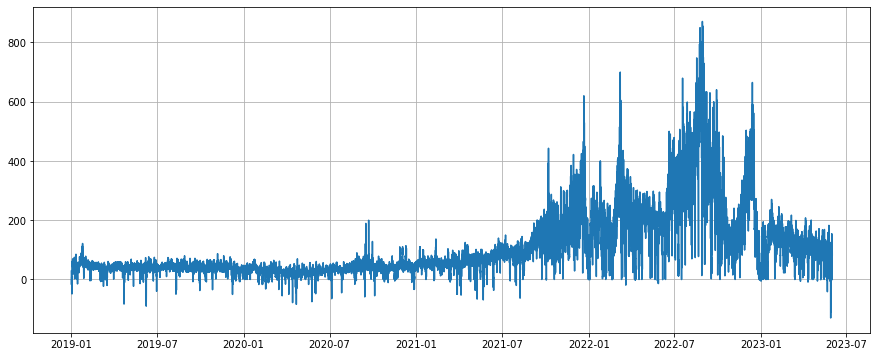

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

In [66]:
df['Price_no_outliers'] = df.Price

Se añaden variables auxiliares

In [67]:
df['Price_24'] = df.Price.shift(24)
df['Price_48'] = df.Price.shift(48)
df['Price_72'] = df.Price.shift(72)
df['Price_96'] = df.Price.shift(96)
df['Price_120'] = df.Price.shift(120)
df['Price_144'] = df.Price.shift(144)
df['Price_168'] = df.Price.shift(168)

In [68]:
df["diff_Price_24"] = df.Price - df.Price_24
df["lower_quantile_diff_Price_24"] = np.nan
df["upper_quantile_diff_Price_24"] = np.nan
for idx in range(len(df)):
    if idx >= 168:
        df_aux = df.loc[idx - 168 : idx - 1]
        df.loc[idx, "lower_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.025
        )
        df.loc[idx, "upper_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.975
        )

df["outlier"] = 0
df.loc[
    (df.diff_Price_24 < df.lower_quantile_diff_Price_24)
    | (df.diff_Price_24 > df.upper_quantile_diff_Price_24),
    "outlier",
] = 1

# df["Price_no_outliers"] = df["Price"]
col = df.loc[
    :,
    [
        "Price_24",
        "Price_48",
        "Price_72",
        "Price_96",
        "Price_120",
        "Price_144",
        "Price_168",
    ],
]
df["Price_median"] = col.median(axis=1)
df.loc[df.outlier == 1, "Price_no_outliers"] = df[
    df.outlier == 1
].Price_median

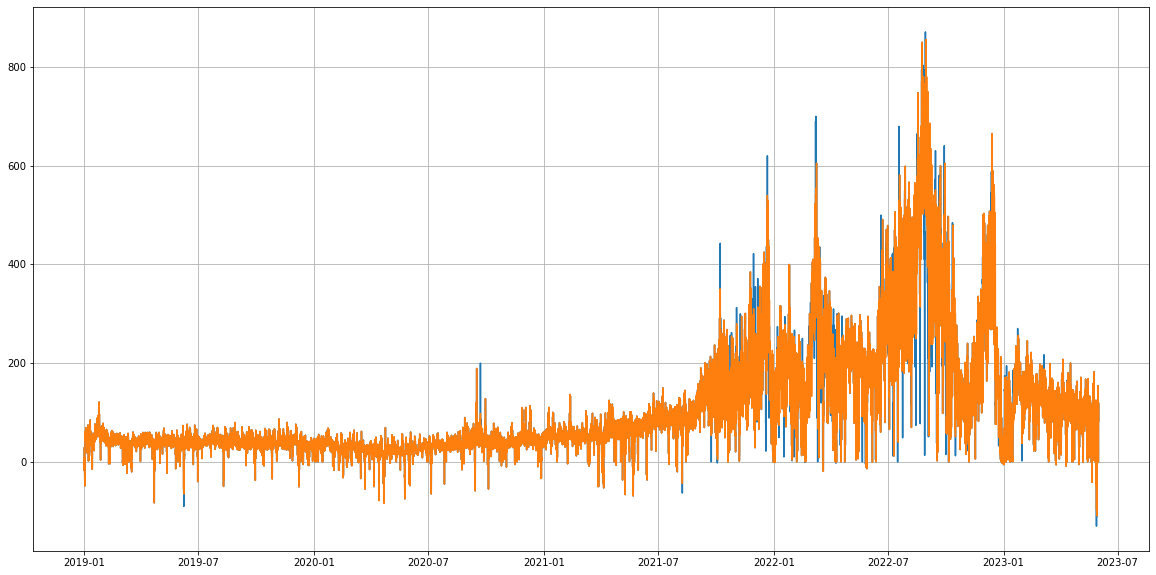

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(df.Date, df.Price)
ax.plot(df.Date, df.Price_no_outliers)
ax.grid()

In [70]:
df = df[['Date', 'Price', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']]

In [71]:
df.index = df.Date

In [72]:
df = df.drop(['Date'], axis = 1)

In [73]:
# names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# for i, x in enumerate(names):
#     df[x] = (pd.to_datetime(df['Simple Date']).dt.weekday == i).astype(int)

In [74]:
# for hora in range(24):
#     df['Price_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Price_hora = df_fecha[df_fecha.Hour == hora].Price.values[0]
        
#         df.loc[df_fecha.index, 'Price_hora_'+str(hora)] = Price_hora

In [75]:
# for col in ['Price_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
#     df[col+"_"+str(48)] = df[col].shift(48)
#     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)

In [76]:
# for hora in range(24):
#     df['Exogenous 1_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Exogenous_1_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 1'].values[0]
        
#         df.loc[df_fecha.index, 'Exogenous 1_hora_'+str(hora)] = Exogenous_1_hora

In [77]:
# for hora in range(24):
#     df['Exogenous 2_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Exogenous_2_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 2'].values[0]
        
#         df.loc[df_fecha.index, 'Exogenous 2_hora_'+str(hora)] = Exogenous_2_hora

In [78]:
# for col in ['Exogenous 1_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
# #     df[col+"_"+str(48)] = df[col].shift(48)
# #     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)
# for col in ['Exogenous 2_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
# #     df[col+"_"+str(48)] = df[col].shift(48)
# #     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)

In [79]:
# list(df.columns)

In [80]:
df

,Price,Price_no_outliers,Exogenous 1,Exogenous 2,Simple Date,Hour
Date,,,,,,
2019-01-01 00:00:00,28.32,28.32,44216.0,23266.0,2019-01-01,0
2019-01-01 01:00:00,10.07,10.07,42397.0,25111.0,2019-01-01,1
2019-01-01 02:00:00,-4.08,-4.08,40788.0,26717.0,2019-01-01,2
2019-01-01 03:00:00,-9.91,-9.91,40307.0,28512.0,2019-01-01,3
2019-01-01 04:00:00,-7.41,-7.41,40479.0,29911.0,2019-01-01,4
...,...,...,...,...,...,...
2023-05-31 19:00:00,108.26,108.26,57968.0,20056.0,2023-05-31,19
2023-05-31 20:00:00,119.60,119.60,56582.0,15227.0,2023-05-31,20
2023-05-31 21:00:00,103.69,103.69,54087.0,14630.0,2023-05-31,21


In [81]:
df['Date'] = df.index

In [82]:
df = df.reset_index(drop=True)

In [83]:
columnas = ['Date',
 'Price',
 'Price_no_outliers',
 'Exogenous 1',
 'Exogenous 2',
 'Simple Date',
 'Hour',
#  'Price_24',
#  'Price_48',
#  'Price_72',
#  'Price_168',
#  'Price_hora_0',
#  'Price_hora_1',
#  'Price_hora_2',
#  'Price_hora_3',
#  'Price_hora_4',
#  'Price_hora_5',
#  'Price_hora_6',
#  'Price_hora_7',
#  'Price_hora_8',
#  'Price_hora_9',
#  'Price_hora_10',
#  'Price_hora_11',
#  'Price_hora_12',
#  'Price_hora_13',
#  'Price_hora_14',
#  'Price_hora_15',
#  'Price_hora_16',
#  'Price_hora_17',
#  'Price_hora_18',
#  'Price_hora_19',
#  'Price_hora_20',
#  'Price_hora_21',
#  'Price_hora_22',
#  'Price_hora_23',
#  'Price_hora_0_24',
#  'Price_hora_0_48',
#  'Price_hora_0_72',
#  'Price_hora_0_168',
#  'Price_hora_1_24',
#  'Price_hora_1_48',
#  'Price_hora_1_72',
#  'Price_hora_1_168',
#  'Price_hora_2_24',
#  'Price_hora_2_48',
#  'Price_hora_2_72',
#  'Price_hora_2_168',
#  'Price_hora_3_24',
#  'Price_hora_3_48',
#  'Price_hora_3_72',
#  'Price_hora_3_168',
#  'Price_hora_4_24',
#  'Price_hora_4_48',
#  'Price_hora_4_72',
#  'Price_hora_4_168',
#  'Price_hora_5_24',
#  'Price_hora_5_48',
#  'Price_hora_5_72',
#  'Price_hora_5_168',
#  'Price_hora_6_24',
#  'Price_hora_6_48',
#  'Price_hora_6_72',
#  'Price_hora_6_168',
#  'Price_hora_7_24',
#  'Price_hora_7_48',
#  'Price_hora_7_72',
#  'Price_hora_7_168',
#  'Price_hora_8_24',
#  'Price_hora_8_48',
#  'Price_hora_8_72',
#  'Price_hora_8_168',
#  'Price_hora_9_24',
#  'Price_hora_9_48',
#  'Price_hora_9_72',
#  'Price_hora_9_168',
#  'Price_hora_10_24',
#  'Price_hora_10_48',
#  'Price_hora_10_72',
#  'Price_hora_10_168',
#  'Price_hora_11_24',
#  'Price_hora_11_48',
#  'Price_hora_11_72',
#  'Price_hora_11_168',
#  'Price_hora_12_24',
#  'Price_hora_12_48',
#  'Price_hora_12_72',
#  'Price_hora_12_168',
#  'Price_hora_13_24',
#  'Price_hora_13_48',
#  'Price_hora_13_72',
#  'Price_hora_13_168',
#  'Price_hora_14_24',
#  'Price_hora_14_48',
#  'Price_hora_14_72',
#  'Price_hora_14_168',
#  'Price_hora_15_24',
#  'Price_hora_15_48',
#  'Price_hora_15_72',
#  'Price_hora_15_168',
#  'Price_hora_16_24',
#  'Price_hora_16_48',
#  'Price_hora_16_72',
#  'Price_hora_16_168',
#  'Price_hora_17_24',
#  'Price_hora_17_48',
#  'Price_hora_17_72',
#  'Price_hora_17_168',
#  'Price_hora_18_24',
#  'Price_hora_18_48',
#  'Price_hora_18_72',
#  'Price_hora_18_168',
#  'Price_hora_19_24',
#  'Price_hora_19_48',
#  'Price_hora_19_72',
#  'Price_hora_19_168',
#  'Price_hora_20_24',
#  'Price_hora_20_48',
#  'Price_hora_20_72',
#  'Price_hora_20_168',
#  'Price_hora_21_24',
#  'Price_hora_21_48',
#  'Price_hora_21_72',
#  'Price_hora_21_168',
#  'Price_hora_22_24',
#  'Price_hora_22_48',
#  'Price_hora_22_72',
#  'Price_hora_22_168',
#  'Price_hora_23_24',
#  'Price_hora_23_48',
#  'Price_hora_23_72',
#  'Price_hora_23_168',
#  'Exogenous 1_hora_0',
#  'Exogenous 1_hora_1',
#  'Exogenous 1_hora_2',
#  'Exogenous 1_hora_3',
#  'Exogenous 1_hora_4',
#  'Exogenous 1_hora_5',
#  'Exogenous 1_hora_6',
#  'Exogenous 1_hora_7',
#  'Exogenous 1_hora_8',
#  'Exogenous 1_hora_9',
#  'Exogenous 1_hora_10',
#  'Exogenous 1_hora_11',
#  'Exogenous 1_hora_12',
#  'Exogenous 1_hora_13',
#  'Exogenous 1_hora_14',
#  'Exogenous 1_hora_15',
#  'Exogenous 1_hora_16',
#  'Exogenous 1_hora_17',
#  'Exogenous 1_hora_18',
#  'Exogenous 1_hora_19',
#  'Exogenous 1_hora_20',
#  'Exogenous 1_hora_21',
#  'Exogenous 1_hora_22',
#  'Exogenous 1_hora_23',
#  'Exogenous 2_hora_0',
#  'Exogenous 2_hora_1',
#  'Exogenous 2_hora_2',
#  'Exogenous 2_hora_3',
#  'Exogenous 2_hora_4',
#  'Exogenous 2_hora_5',
#  'Exogenous 2_hora_6',
#  'Exogenous 2_hora_7',
#  'Exogenous 2_hora_8',
#  'Exogenous 2_hora_9',
#  'Exogenous 2_hora_10',
#  'Exogenous 2_hora_11',
#  'Exogenous 2_hora_12',
#  'Exogenous 2_hora_13',
#  'Exogenous 2_hora_14',
#  'Exogenous 2_hora_15',
#  'Exogenous 2_hora_16',
#  'Exogenous 2_hora_17',
#  'Exogenous 2_hora_18',
#  'Exogenous 2_hora_19',
#  'Exogenous 2_hora_20',
#  'Exogenous 2_hora_21',
#  'Exogenous 2_hora_22',
#  'Exogenous 2_hora_23',
#  'Exogenous 1_hora_0_24',
#  'Exogenous 1_hora_0_168',
#  'Exogenous 1_hora_1_24',
#  'Exogenous 1_hora_1_168',
#  'Exogenous 1_hora_2_24',
#  'Exogenous 1_hora_2_168',
#  'Exogenous 1_hora_3_24',
#  'Exogenous 1_hora_3_168',
#  'Exogenous 1_hora_4_24',
#  'Exogenous 1_hora_4_168',
#  'Exogenous 1_hora_5_24',
#  'Exogenous 1_hora_5_168',
#  'Exogenous 1_hora_6_24',
#  'Exogenous 1_hora_6_168',
#  'Exogenous 1_hora_7_24',
#  'Exogenous 1_hora_7_168',
#  'Exogenous 1_hora_8_24',
#  'Exogenous 1_hora_8_168',
#  'Exogenous 1_hora_9_24',
#  'Exogenous 1_hora_9_168',
#  'Exogenous 1_hora_10_24',
#  'Exogenous 1_hora_10_168',
#  'Exogenous 1_hora_11_24',
#  'Exogenous 1_hora_11_168',
#  'Exogenous 1_hora_12_24',
#  'Exogenous 1_hora_12_168',
#  'Exogenous 1_hora_13_24',
#  'Exogenous 1_hora_13_168',
#  'Exogenous 1_hora_14_24',
#  'Exogenous 1_hora_14_168',
#  'Exogenous 1_hora_15_24',
#  'Exogenous 1_hora_15_168',
#  'Exogenous 1_hora_16_24',
#  'Exogenous 1_hora_16_168',
#  'Exogenous 1_hora_17_24',
#  'Exogenous 1_hora_17_168',
#  'Exogenous 1_hora_18_24',
#  'Exogenous 1_hora_18_168',
#  'Exogenous 1_hora_19_24',
#  'Exogenous 1_hora_19_168',
#  'Exogenous 1_hora_20_24',
#  'Exogenous 1_hora_20_168',
#  'Exogenous 1_hora_21_24',
#  'Exogenous 1_hora_21_168',
#  'Exogenous 1_hora_22_24',
#  'Exogenous 1_hora_22_168',
#  'Exogenous 1_hora_23_24',
#  'Exogenous 1_hora_23_168',
#  'Exogenous 2_hora_0_24',
#  'Exogenous 2_hora_0_168',
#  'Exogenous 2_hora_1_24',
#  'Exogenous 2_hora_1_168',
#  'Exogenous 2_hora_2_24',
#  'Exogenous 2_hora_2_168',
#  'Exogenous 2_hora_3_24',
#  'Exogenous 2_hora_3_168',
#  'Exogenous 2_hora_4_24',
#  'Exogenous 2_hora_4_168',
#  'Exogenous 2_hora_5_24',
#  'Exogenous 2_hora_5_168',
#  'Exogenous 2_hora_6_24',
#  'Exogenous 2_hora_6_168',
#  'Exogenous 2_hora_7_24',
#  'Exogenous 2_hora_7_168',
#  'Exogenous 2_hora_8_24',
#  'Exogenous 2_hora_8_168',
#  'Exogenous 2_hora_9_24',
#  'Exogenous 2_hora_9_168',
#  'Exogenous 2_hora_10_24',
#  'Exogenous 2_hora_10_168',
#  'Exogenous 2_hora_11_24',
#  'Exogenous 2_hora_11_168',
#  'Exogenous 2_hora_12_24',
#  'Exogenous 2_hora_12_168',
#  'Exogenous 2_hora_13_24',
#  'Exogenous 2_hora_13_168',
#  'Exogenous 2_hora_14_24',
#  'Exogenous 2_hora_14_168',
#  'Exogenous 2_hora_15_24',
#  'Exogenous 2_hora_15_168',
#  'Exogenous 2_hora_16_24',
#  'Exogenous 2_hora_16_168',
#  'Exogenous 2_hora_17_24',
#  'Exogenous 2_hora_17_168',
#  'Exogenous 2_hora_18_24',
#  'Exogenous 2_hora_18_168',
#  'Exogenous 2_hora_19_24',
#  'Exogenous 2_hora_19_168',
#  'Exogenous 2_hora_20_24',
#  'Exogenous 2_hora_20_168',
#  'Exogenous 2_hora_21_24',
#  'Exogenous 2_hora_21_168',
#  'Exogenous 2_hora_22_24',
#  'Exogenous 2_hora_22_168',
#  'Exogenous 2_hora_23_24',
#  'Exogenous 2_hora_23_168'
           ]

# columnas_post = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
#        'Saturday', 'Sunday']

In [84]:
def standard_movil(df):
    columnas = list(df.columns)
    dict_new_df = {col: [] for col in columnas}
    columnas.remove('Date')
    columnas.remove('Simple Date')
    columnas.remove('Hour')
    dict_new_df['scaler'] = []
    dict_new_df['Price_real'] = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        if index >= 168*1:
            dict_new_df['Date'].append(row.Date)
            dict_new_df['Simple Date'].append(row['Simple Date'])
            dict_new_df['Hour'].append(row.Hour)
            df_aux = df[(pd.to_datetime(df['Simple Date']) < pd.to_datetime(row['Simple Date'])) & (pd.to_datetime(df['Simple Date']) >= pd.to_datetime(row['Simple Date']) - dt.timedelta(days=7))]
            for col in columnas:
                df_aux_col = df_aux[col].to_numpy().reshape(-1, 1)
                scaler = StandardScaler()
                scaler.fit(df_aux_col)
                if col == 'Price':
                    dict_new_df['Price_real'].append(row[col])
#                     if np.abs(scaler.transform(np.array(row[col]).reshape(1, -1))[0][0]) > 5:
#                         scaler.scale_ =  np.abs((row[col] - scaler.mean_)/5)
                elif col == 'Price_no_outliers':
                    dict_new_df['scaler'].append(scaler)
                dict_new_df[col].append(scaler.transform(np.array(row[col]).reshape(1, -1))[0][0])
    return dict_new_df

In [85]:
dict_new_df = standard_movil(df[columnas])

100%|████████████████████████████████████████████████████████████████████████████| 38688/38688 [08:54<00:00, 72.37it/s]


In [86]:
df = df.drop(df.head(168).index)

In [87]:
with open('dict_new_df_alemania_final_no_outliers.pkl', 'wb') as f:
    pickle.dump(dict_new_df, f)

In [88]:
# df = df.drop(df.head(168).index)

In [89]:
# with open('dict_new_df_be_epftoolbox_final_no_outliers.pkl', 'rb') as handle:
#     dict_new_df = pickle.load(handle)

In [90]:
for k, v in dict_new_df.items():
    print(k, len(v))

Date 38520
Price 38520
Price_no_outliers 38520
Exogenous 1 38520
Exogenous 2 38520
Simple Date 38520
Hour 38520
scaler 38520
Price_real 38520


In [91]:
df_nuevo = pd.DataFrame(dict_new_df)

In [92]:
# for col in columnas_post:
#     df_nuevo[col] = df[col].to_numpy()

In [93]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [94]:
df_scalers

,Date,scaler
0,2019-01-08 00:00:00,StandardScaler()
1,2019-01-08 01:00:00,StandardScaler()
2,2019-01-08 02:00:00,StandardScaler()
3,2019-01-08 03:00:00,StandardScaler()
4,2019-01-08 04:00:00,StandardScaler()
...,...,...
38515,2023-05-31 19:00:00,StandardScaler()
38516,2023-05-31 20:00:00,StandardScaler()
38517,2023-05-31 21:00:00,StandardScaler()
38518,2023-05-31 22:00:00,StandardScaler()


In [95]:
df_nuevo = df_nuevo[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']].rename(columns={'Price_no_outliers':'Price'})

In [96]:
df = df_nuevo

In [97]:
df.index = df.Date

In [98]:
df = df.drop(['Date'], axis = 1)

In [99]:
df_train = df[df.index < dt.datetime(2022, 1, 1)]
df_test = df[df.index >= dt.datetime(2022, 1, 1)]

In [100]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [101]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [102]:
forecast_dates = forecast.index

In [103]:
from epftoolbox.models._lear import LEAR_adaptive_normalization as LEAR

In [104]:
calibration_window = 2*364

In [105]:
model = LEAR(calibration_window=calibration_window)

In [106]:
df_scalers[(df_scalers.Date >= forecast_dates[0]) & (df_scalers.Date <= forecast_dates[0] + pd.Timedelta(hours=23))].scaler.to_numpy()

array([StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler()], dtype=object)

In [107]:
df_original = pd.read_csv(r"Data\df_alemania_final.csv")

In [108]:
df_original['Date'] = pd.to_datetime(df_original.Date)
df_original['Simple Date'] = df_original.Date.dt.strftime("%Y-%m-%d")
df_original['Hour'] = df_original.Date.dt.hour

In [109]:
df_original = df_original.fillna(0)

In [110]:
df_original.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Simple Date    0
Hour           0
dtype: int64

In [111]:
df_original

,Date,Price,Exogenous 1,Exogenous 2,Exogenous 3,Simple Date,Hour
0,2019-01-01 00:00:00,28.32,44216.0,0.0,23266.0,2019-01-01,0
1,2019-01-01 01:00:00,10.07,42397.0,0.0,25111.0,2019-01-01,1
2,2019-01-01 02:00:00,-4.08,40788.0,0.0,26717.0,2019-01-01,2
3,2019-01-01 03:00:00,-9.91,40307.0,0.0,28512.0,2019-01-01,3
4,2019-01-01 04:00:00,-7.41,40479.0,0.0,29911.0,2019-01-01,4
...,...,...,...,...,...,...,...
38683,2023-05-31 19:00:00,108.26,57968.0,7000.0,13056.0,2023-05-31,19
38684,2023-05-31 20:00:00,119.60,56582.0,2149.0,13078.0,2023-05-31,20
38685,2023-05-31 21:00:00,103.69,54087.0,276.0,14354.0,2023-05-31,21
38686,2023-05-31 22:00:00,94.28,51883.0,0.0,16051.0,2023-05-31,22


In [112]:
df_original['Exogenous 2'] = df_original['Exogenous 2'] + df_original['Exogenous 3']
df_original = df_original.drop(['Exogenous 3'], axis = 1)

In [113]:
df_original.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [114]:
df_original.index = df_original.Date

In [115]:
df_original = df_original.drop('Date', axis = 1)

In [116]:
df_original = df_original.drop(['Simple Date', 'Hour'], axis = 1)

In [117]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [118]:
df_original = df_original[df_original.index >= dt.datetime(2022, 1, 1)]

In [119]:
real_values = df_original[df_original.index >= dt.datetime(2022, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [120]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,50.05,41.33,43.22,45.46,37.67,39.70,40.59,43.26,49.66,70.05,...,97.17,101.00,126.60,149.97,146.33,140.28,121.88,102.61,97.46,85.16
2022-01-02,57.08,52.59,48.97,34.94,29.56,33.97,34.52,41.80,48.95,60.01,...,40.01,29.11,32.76,42.97,60.96,60.94,54.12,46.16,46.29,32.93
2022-01-03,0.31,-0.01,-0.07,-1.05,-1.00,0.32,37.55,88.76,122.93,110.17,...,80.99,98.05,123.51,148.49,138.00,117.64,117.71,95.95,105.68,95.26
2022-01-04,103.70,108.27,105.92,103.41,102.71,114.23,156.91,182.64,178.91,190.00,...,179.00,180.93,166.69,189.88,184.94,178.99,156.12,140.92,137.92,97.56
2022-01-05,105.31,97.29,84.50,75.38,79.11,94.79,99.16,101.15,129.56,113.37,...,107.32,119.48,137.28,148.09,139.88,135.75,119.93,98.09,118.71,99.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,89.69,83.53,84.73,86.33,91.25,90.00,82.70,82.99,72.61,55.06,...,-2.39,0.51,2.26,55.08,84.85,100.38,124.93,113.08,100.03,94.71
2023-05-28,87.09,84.00,81.92,77.87,77.86,76.47,72.02,64.84,37.70,0.00,...,-129.96,-98.08,-18.68,-0.06,50.00,72.90,80.01,77.84,73.80,69.50
2023-05-29,59.23,53.90,51.82,48.51,54.52,63.36,67.65,58.71,29.92,0.00,...,-109.45,-80.69,-19.97,-4.98,19.20,72.08,83.75,85.88,80.48,74.26


In [121]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 97.16%  |  MAE: 39.560
2022-01-02 - sMAPE: 68.94%  |  MAE: 26.851
2022-01-03 - sMAPE: 64.90%  |  MAE: 24.045
2022-01-04 - sMAPE: 51.23%  |  MAE: 21.888
2022-01-05 - sMAPE: 45.08%  |  MAE: 21.501
2022-01-06 - sMAPE: 40.72%  |  MAE: 23.523
2022-01-07 - sMAPE: 40.33%  |  MAE: 28.157
2022-01-08 - sMAPE: 38.42%  |  MAE: 29.443
2022-01-09 - sMAPE: 36.77%  |  MAE: 29.773
2022-01-10 - sMAPE: 35.47%  |  MAE: 31.853
2022-01-11 - sMAPE: 33.41%  |  MAE: 31.646
2022-01-12 - sMAPE: 31.11%  |  MAE: 30.112
2022-01-13 - sMAPE: 29.57%  |  MAE: 29.347
2022-01-14 - sMAPE: 28.24%  |  MAE: 28.716
2022-01-15 - sMAPE: 26.79%  |  MAE: 27.670
2022-01-16 - sMAPE: 26.23%  |  MAE: 27.477
2022-01-17 - sMAPE: 27.80%  |  MAE: 29.242
2022-01-18 - sMAPE: 26.51%  |  MAE: 28.206
2022-01-19 - sMAPE: 25.93%  |  MAE: 28.135
2022-01-20 - sMAPE: 26.15%  |  MAE: 28.736
2022-01-21 - sMAPE: 25.38%  |  MAE: 28.158
2022-01-22 - sMAPE: 24.51%  |  MAE: 27.384
2022-01-23 - sMAPE: 23.75%  |  MAE: 26.735
2022-01-24 

2022-07-11 - sMAPE: 26.36%  |  MAE: 35.940
2022-07-12 - sMAPE: 26.27%  |  MAE: 35.915
2022-07-13 - sMAPE: 26.16%  |  MAE: 35.803
2022-07-14 - sMAPE: 26.08%  |  MAE: 35.804
2022-07-15 - sMAPE: 26.00%  |  MAE: 35.778
2022-07-16 - sMAPE: 26.30%  |  MAE: 36.153
2022-07-17 - sMAPE: 26.34%  |  MAE: 36.279
2022-07-18 - sMAPE: 26.27%  |  MAE: 36.360
2022-07-19 - sMAPE: 26.19%  |  MAE: 36.390
2022-07-20 - sMAPE: 26.14%  |  MAE: 36.466
2022-07-21 - sMAPE: 26.04%  |  MAE: 36.411
2022-07-22 - sMAPE: 25.95%  |  MAE: 36.353
2022-07-23 - sMAPE: 25.89%  |  MAE: 36.400
2022-07-24 - sMAPE: 25.94%  |  MAE: 36.558
2022-07-25 - sMAPE: 25.89%  |  MAE: 36.597
2022-07-26 - sMAPE: 25.85%  |  MAE: 36.666
2022-07-27 - sMAPE: 25.81%  |  MAE: 36.823
2022-07-28 - sMAPE: 25.78%  |  MAE: 37.033
2022-07-29 - sMAPE: 25.67%  |  MAE: 36.919
2022-07-30 - sMAPE: 25.59%  |  MAE: 36.892
2022-07-31 - sMAPE: 25.55%  |  MAE: 36.968
2022-08-01 - sMAPE: 25.47%  |  MAE: 36.952
2022-08-02 - sMAPE: 25.39%  |  MAE: 36.933
2022-08-03 

2023-01-18 - sMAPE: 26.17%  |  MAE: 40.503
2023-01-19 - sMAPE: 26.12%  |  MAE: 40.431
2023-01-20 - sMAPE: 26.08%  |  MAE: 40.366
2023-01-21 - sMAPE: 26.03%  |  MAE: 40.288
2023-01-22 - sMAPE: 25.99%  |  MAE: 40.225
2023-01-23 - sMAPE: 25.96%  |  MAE: 40.186
2023-01-24 - sMAPE: 25.90%  |  MAE: 40.105
2023-01-25 - sMAPE: 25.86%  |  MAE: 40.047
2023-01-26 - sMAPE: 25.82%  |  MAE: 39.993
2023-01-27 - sMAPE: 25.76%  |  MAE: 39.909
2023-01-28 - sMAPE: 25.73%  |  MAE: 39.851
2023-01-29 - sMAPE: 25.77%  |  MAE: 39.840
2023-01-30 - sMAPE: 25.82%  |  MAE: 39.790
2023-01-31 - sMAPE: 25.81%  |  MAE: 39.758
2023-02-01 - sMAPE: 25.77%  |  MAE: 39.686
2023-02-02 - sMAPE: 25.75%  |  MAE: 39.640
2023-02-03 - sMAPE: 25.73%  |  MAE: 39.592
2023-02-04 - sMAPE: 25.71%  |  MAE: 39.558
2023-02-05 - sMAPE: 25.67%  |  MAE: 39.490
2023-02-06 - sMAPE: 25.63%  |  MAE: 39.442
2023-02-07 - sMAPE: 25.59%  |  MAE: 39.372
2023-02-08 - sMAPE: 25.55%  |  MAE: 39.319
2023-02-09 - sMAPE: 25.52%  |  MAE: 39.263
2023-02-10 

In [122]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,2.527979,-0.939649,3.796262,0.583697,1.10108,-1.115289,-41.279136,-27.947271,1.421079,34.831647,...,47.076867,67.859207,99.090596,127.102504,118.532567,103.46285,83.464942,64.264377,75.44402,61.311107
2022-01-02,63.074743,45.228874,42.300042,32.786138,31.329542,29.433444,37.304296,51.282855,70.556651,77.791988,...,-10.215308,5.065294,25.608392,65.593324,73.269607,51.944584,39.507589,24.15908,37.984642,11.450031
2022-01-03,8.291095,-0.041868,0.849628,-6.352585,-0.895034,22.293604,43.345291,82.31343,100.455386,102.583841,...,42.21606,60.623359,81.572731,144.306608,127.010804,102.672611,88.856497,76.829186,77.469848,63.33173
2022-01-04,79.555456,93.533164,101.64445,105.894563,117.14927,124.629767,146.188886,182.022382,208.947929,220.199191,...,180.499553,181.688736,194.23598,214.489195,189.392048,171.09825,147.485816,114.862983,109.362204,90.751593
2022-01-05,78.746785,71.709401,60.416528,52.39491,50.102754,59.933781,81.86767,129.778651,148.787516,154.035153,...,99.475417,105.682554,127.823103,171.195301,154.189759,144.407043,116.147381,100.36746,99.654894,75.154604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,78.893027,70.274833,65.830915,63.079241,61.911161,66.297404,76.966217,84.674825,87.098748,70.251636,...,11.878224,16.614055,40.235754,63.388423,92.160471,122.317579,126.18853,121.001572,111.928004,101.283964
2023-05-28,86.652433,76.122835,71.546868,68.847685,64.929155,66.046487,66.46957,65.541001,72.265173,60.403182,...,2.858863,4.377747,31.287078,56.486265,77.622476,102.409671,110.285005,103.285201,95.110153,82.105983
2023-05-29,62.394625,54.103611,49.887257,48.384647,45.722381,49.450896,56.712936,63.590974,63.56735,48.493152,...,-19.075688,-13.362794,15.39154,42.978348,70.84526,94.888017,96.586277,92.760535,86.999322,70.562395


In [123]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_alemania_final_2_anos_ventana_no_outliers.csv")

In [124]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [125]:
forecast_dates = forecast.index

In [126]:
calibration_window = 1*364

In [127]:
model = LEAR(calibration_window=calibration_window)

In [128]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 69.44%  |  MAE: 35.595
2022-01-02 - sMAPE: 48.58%  |  MAE: 24.253
2022-01-03 - sMAPE: 55.13%  |  MAE: 23.135
2022-01-04 - sMAPE: 44.39%  |  MAE: 21.138
2022-01-05 - sMAPE: 41.86%  |  MAE: 22.987
2022-01-06 - sMAPE: 39.26%  |  MAE: 26.336
2022-01-07 - sMAPE: 38.99%  |  MAE: 30.137
2022-01-08 - sMAPE: 37.40%  |  MAE: 31.400
2022-01-09 - sMAPE: 35.47%  |  MAE: 31.124
2022-01-10 - sMAPE: 34.50%  |  MAE: 33.605
2022-01-11 - sMAPE: 32.43%  |  MAE: 32.981
2022-01-12 - sMAPE: 30.21%  |  MAE: 31.409
2022-01-13 - sMAPE: 28.89%  |  MAE: 30.885
2022-01-14 - sMAPE: 27.64%  |  MAE: 30.217
2022-01-15 - sMAPE: 26.19%  |  MAE: 29.008
2022-01-16 - sMAPE: 25.95%  |  MAE: 29.193
2022-01-17 - sMAPE: 27.63%  |  MAE: 31.020
2022-01-18 - sMAPE: 26.40%  |  MAE: 29.981
2022-01-19 - sMAPE: 25.91%  |  MAE: 29.985
2022-01-20 - sMAPE: 26.19%  |  MAE: 30.599
2022-01-21 - sMAPE: 25.41%  |  MAE: 29.938
2022-01-22 - sMAPE: 24.57%  |  MAE: 29.114
2022-01-23 - sMAPE: 23.77%  |  MAE: 28.354
2022-01-24 

2022-07-11 - sMAPE: 27.56%  |  MAE: 38.602
2022-07-12 - sMAPE: 27.48%  |  MAE: 38.612
2022-07-13 - sMAPE: 27.37%  |  MAE: 38.500
2022-07-14 - sMAPE: 27.30%  |  MAE: 38.522
2022-07-15 - sMAPE: 27.20%  |  MAE: 38.458
2022-07-16 - sMAPE: 27.51%  |  MAE: 38.935
2022-07-17 - sMAPE: 27.58%  |  MAE: 39.151
2022-07-18 - sMAPE: 27.52%  |  MAE: 39.246
2022-07-19 - sMAPE: 27.44%  |  MAE: 39.256
2022-07-20 - sMAPE: 27.38%  |  MAE: 39.309
2022-07-21 - sMAPE: 27.28%  |  MAE: 39.263
2022-07-22 - sMAPE: 27.17%  |  MAE: 39.151
2022-07-23 - sMAPE: 27.11%  |  MAE: 39.210
2022-07-24 - sMAPE: 27.18%  |  MAE: 39.436
2022-07-25 - sMAPE: 27.12%  |  MAE: 39.463
2022-07-26 - sMAPE: 27.07%  |  MAE: 39.516
2022-07-27 - sMAPE: 27.04%  |  MAE: 39.706
2022-07-28 - sMAPE: 27.01%  |  MAE: 39.942
2022-07-29 - sMAPE: 26.91%  |  MAE: 39.862
2022-07-30 - sMAPE: 26.83%  |  MAE: 39.861
2022-07-31 - sMAPE: 26.80%  |  MAE: 39.966
2022-08-01 - sMAPE: 26.71%  |  MAE: 39.945
2022-08-02 - sMAPE: 26.63%  |  MAE: 39.888
2022-08-03 

2023-01-18 - sMAPE: 27.74%  |  MAE: 43.177
2023-01-19 - sMAPE: 27.70%  |  MAE: 43.101
2023-01-20 - sMAPE: 27.65%  |  MAE: 43.038
2023-01-21 - sMAPE: 27.61%  |  MAE: 42.967
2023-01-22 - sMAPE: 27.56%  |  MAE: 42.898
2023-01-23 - sMAPE: 27.52%  |  MAE: 42.849
2023-01-24 - sMAPE: 27.46%  |  MAE: 42.766
2023-01-25 - sMAPE: 27.42%  |  MAE: 42.705
2023-01-26 - sMAPE: 27.38%  |  MAE: 42.647
2023-01-27 - sMAPE: 27.32%  |  MAE: 42.557
2023-01-28 - sMAPE: 27.28%  |  MAE: 42.498
2023-01-29 - sMAPE: 27.30%  |  MAE: 42.473
2023-01-30 - sMAPE: 27.37%  |  MAE: 42.430
2023-01-31 - sMAPE: 27.38%  |  MAE: 42.406
2023-02-01 - sMAPE: 27.33%  |  MAE: 42.322
2023-02-02 - sMAPE: 27.31%  |  MAE: 42.284
2023-02-03 - sMAPE: 27.29%  |  MAE: 42.235
2023-02-04 - sMAPE: 27.27%  |  MAE: 42.197
2023-02-05 - sMAPE: 27.23%  |  MAE: 42.129
2023-02-06 - sMAPE: 27.19%  |  MAE: 42.073
2023-02-07 - sMAPE: 27.15%  |  MAE: 42.001
2023-02-08 - sMAPE: 27.11%  |  MAE: 41.954
2023-02-09 - sMAPE: 27.08%  |  MAE: 41.896
2023-02-10 

In [129]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,14.130168,17.831453,20.635705,21.282053,27.934921,22.879833,-9.548417,-8.31236,31.006598,24.279552,...,43.397507,51.585506,83.957024,110.028225,137.339788,117.43161,65.841725,53.424217,68.449084,61.834111
2022-01-02,68.467482,58.064928,50.789491,47.33985,46.315503,45.079043,42.316315,59.814638,89.364657,77.810865,...,30.011876,25.753261,19.719394,75.500154,77.281925,66.585072,54.995444,30.024206,39.657472,15.864793
2022-01-03,14.156105,2.87959,-6.639933,-12.353846,-8.948987,18.871088,52.86177,89.576565,115.836633,95.137424,...,48.713051,66.673544,79.637088,140.224343,97.871703,85.794356,76.47421,64.910411,66.268233,47.897131
2022-01-04,84.183027,81.809909,82.125148,79.682022,81.429128,97.639088,124.223675,163.755104,187.071845,191.552045,...,167.512236,175.571339,187.873105,199.321452,183.40163,156.004303,145.698523,117.78811,107.806037,89.212665
2022-01-05,77.182284,59.28258,41.784549,32.515577,32.73605,55.845955,105.992041,159.033526,179.856526,157.598709,...,138.286855,146.989878,144.485327,169.947172,133.877937,141.894313,128.971881,99.002209,94.454545,69.103366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,77.380205,70.745763,64.377082,60.701901,59.997404,64.318733,78.596475,89.780485,84.93034,68.020657,...,-2.628274,4.57996,23.701507,57.658481,88.132813,123.17446,128.466193,123.933408,114.225236,100.279781
2023-05-28,83.435822,76.932572,68.784917,65.201259,61.679934,62.876893,61.833136,64.010985,64.568364,50.25224,...,-27.207244,-16.503821,1.85043,41.764573,73.316143,102.040188,112.282528,105.015091,94.311369,80.165159
2023-05-29,60.494977,53.131246,47.952202,45.70952,42.404069,43.775933,49.947487,62.077212,60.253867,43.557844,...,-25.16767,-24.293529,-7.406154,31.888341,68.971943,94.202522,95.232745,88.402411,84.12856,72.70703


In [130]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_alemania_final_1_ano_ventana_no_outliers.csv")

In [131]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [132]:
forecast_dates = forecast.index

In [133]:
calibration_window = 182

In [134]:
model = LEAR(calibration_window=calibration_window)

In [135]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 69.17%  |  MAE: 34.848
2022-01-02 - sMAPE: 53.69%  |  MAE: 27.818
2022-01-03 - sMAPE: 60.59%  |  MAE: 27.215
2022-01-04 - sMAPE: 52.72%  |  MAE: 29.687
2022-01-05 - sMAPE: 48.28%  |  MAE: 29.727
2022-01-06 - sMAPE: 47.20%  |  MAE: 35.780
2022-01-07 - sMAPE: 46.84%  |  MAE: 39.314
2022-01-08 - sMAPE: 44.43%  |  MAE: 39.552
2022-01-09 - sMAPE: 42.16%  |  MAE: 38.780
2022-01-10 - sMAPE: 41.13%  |  MAE: 41.879
2022-01-11 - sMAPE: 38.98%  |  MAE: 41.693
2022-01-12 - sMAPE: 36.04%  |  MAE: 38.914
2022-01-13 - sMAPE: 34.34%  |  MAE: 38.032
2022-01-14 - sMAPE: 32.66%  |  MAE: 36.736
2022-01-15 - sMAPE: 30.92%  |  MAE: 35.136
2022-01-16 - sMAPE: 31.10%  |  MAE: 36.102
2022-01-17 - sMAPE: 32.72%  |  MAE: 38.038
2022-01-18 - sMAPE: 31.44%  |  MAE: 37.164
2022-01-19 - sMAPE: 30.70%  |  MAE: 36.832
2022-01-20 - sMAPE: 31.10%  |  MAE: 37.667
2022-01-21 - sMAPE: 30.13%  |  MAE: 36.742
2022-01-22 - sMAPE: 29.07%  |  MAE: 35.611
2022-01-23 - sMAPE: 28.10%  |  MAE: 34.612
2022-01-24 

2022-07-11 - sMAPE: 28.76%  |  MAE: 40.691
2022-07-12 - sMAPE: 28.67%  |  MAE: 40.663
2022-07-13 - sMAPE: 28.55%  |  MAE: 40.549
2022-07-14 - sMAPE: 28.48%  |  MAE: 40.566
2022-07-15 - sMAPE: 28.39%  |  MAE: 40.504
2022-07-16 - sMAPE: 28.69%  |  MAE: 40.982
2022-07-17 - sMAPE: 28.72%  |  MAE: 41.132
2022-07-18 - sMAPE: 28.66%  |  MAE: 41.242
2022-07-19 - sMAPE: 28.57%  |  MAE: 41.248
2022-07-20 - sMAPE: 28.50%  |  MAE: 41.284
2022-07-21 - sMAPE: 28.40%  |  MAE: 41.247
2022-07-22 - sMAPE: 28.30%  |  MAE: 41.190
2022-07-23 - sMAPE: 28.25%  |  MAE: 41.275
2022-07-24 - sMAPE: 28.31%  |  MAE: 41.473
2022-07-25 - sMAPE: 28.23%  |  MAE: 41.462
2022-07-26 - sMAPE: 28.17%  |  MAE: 41.482
2022-07-27 - sMAPE: 28.14%  |  MAE: 41.677
2022-07-28 - sMAPE: 28.10%  |  MAE: 41.862
2022-07-29 - sMAPE: 27.99%  |  MAE: 41.773
2022-07-30 - sMAPE: 27.91%  |  MAE: 41.761
2022-07-31 - sMAPE: 27.87%  |  MAE: 41.875
2022-08-01 - sMAPE: 27.79%  |  MAE: 41.861
2022-08-02 - sMAPE: 27.70%  |  MAE: 41.796
2022-08-03 

2023-01-18 - sMAPE: 28.50%  |  MAE: 44.421
2023-01-19 - sMAPE: 28.46%  |  MAE: 44.350
2023-01-20 - sMAPE: 28.41%  |  MAE: 44.279
2023-01-21 - sMAPE: 28.37%  |  MAE: 44.213
2023-01-22 - sMAPE: 28.33%  |  MAE: 44.147
2023-01-23 - sMAPE: 28.29%  |  MAE: 44.097
2023-01-24 - sMAPE: 28.22%  |  MAE: 44.006
2023-01-25 - sMAPE: 28.17%  |  MAE: 43.937
2023-01-26 - sMAPE: 28.13%  |  MAE: 43.878
2023-01-27 - sMAPE: 28.07%  |  MAE: 43.783
2023-01-28 - sMAPE: 28.03%  |  MAE: 43.720
2023-01-29 - sMAPE: 28.03%  |  MAE: 43.681
2023-01-30 - sMAPE: 28.07%  |  MAE: 43.624
2023-01-31 - sMAPE: 28.07%  |  MAE: 43.591
2023-02-01 - sMAPE: 28.03%  |  MAE: 43.506
2023-02-02 - sMAPE: 28.00%  |  MAE: 43.461
2023-02-03 - sMAPE: 27.98%  |  MAE: 43.407
2023-02-04 - sMAPE: 27.96%  |  MAE: 43.371
2023-02-05 - sMAPE: 27.92%  |  MAE: 43.298
2023-02-06 - sMAPE: 27.88%  |  MAE: 43.242
2023-02-07 - sMAPE: 27.84%  |  MAE: 43.173
2023-02-08 - sMAPE: 27.81%  |  MAE: 43.127
2023-02-09 - sMAPE: 27.78%  |  MAE: 43.071
2023-02-10 

In [136]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,11.964451,7.322525,16.40486,17.593556,18.383291,11.526293,-21.760091,-7.771273,35.810646,59.910717,...,46.260296,53.259669,97.292607,105.280235,92.854653,70.291009,56.650219,46.620093,64.328419,63.985572
2022-01-02,65.320685,57.590551,49.317341,43.511304,46.634369,31.413419,23.902898,78.699627,98.075717,101.487688,...,57.938278,59.84063,67.745658,85.196322,77.083252,72.303462,50.672744,25.993035,31.443011,14.449606
2022-01-03,12.726165,8.496252,-5.351322,-11.800383,-7.282545,20.327779,59.93525,104.393751,122.731778,102.051967,...,41.249676,45.251319,60.822028,97.403364,101.483624,87.843229,55.883438,55.382599,59.803668,43.681506
2022-01-04,73.163572,65.175584,71.48286,68.365319,72.527069,79.649439,100.756683,143.279644,146.421896,148.213341,...,124.596089,122.475886,151.480523,170.509732,174.618962,147.665702,134.801335,109.026231,94.610704,77.903651
2022-01-05,71.144067,62.324943,41.613003,30.499718,39.14136,60.038973,123.162868,180.019775,195.560899,177.795628,...,119.095959,130.117355,122.56911,155.163935,145.465078,147.127134,124.628128,104.943482,93.932276,72.423076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,81.843406,78.568826,77.551947,74.229752,75.199854,77.629523,83.509559,83.159531,76.182125,56.897183,...,-13.142496,-4.277527,19.934589,60.273995,93.5293,122.651054,124.372072,116.573689,108.283857,100.436121
2023-05-28,93.880814,84.88679,81.127311,77.25069,76.942466,74.329884,69.082754,58.109878,48.848102,35.240951,...,-25.259232,-21.618974,2.111071,50.31768,84.603197,101.337977,109.135303,105.51927,96.280111,88.552783
2023-05-29,63.332554,54.759357,52.168167,52.399258,55.37176,55.695083,58.46885,56.288438,49.603353,33.113881,...,-21.269591,-23.507999,-0.565642,37.826977,77.169427,101.69441,95.329125,90.001721,82.450236,68.869267


In [137]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_alemania_final_6_meses_ventana_no_outliers.csv")

In [138]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [139]:
forecast_dates = forecast.index

In [140]:
calibration_window = None

In [141]:
model = LEAR(calibration_window=calibration_window)

In [142]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2022-01-01 - sMAPE: 91.31%  |  MAE: 35.323
2022-01-02 - sMAPE: 66.34%  |  MAE: 24.373
2022-01-03 - sMAPE: 66.13%  |  MAE: 22.567
2022-01-04 - sMAPE: 52.86%  |  MAE: 21.991
2022-01-05 - sMAPE: 47.19%  |  MAE: 21.545
2022-01-06 - sMAPE: 42.66%  |  MAE: 23.499
2022-01-07 - sMAPE: 41.98%  |  MAE: 27.956
2022-01-08 - sMAPE: 40.16%  |  MAE: 29.657
2022-01-09 - sMAPE: 38.68%  |  MAE: 30.339
2022-01-10 - sMAPE: 37.06%  |  MAE: 32.141
2022-01-11 - sMAPE: 35.10%  |  MAE: 32.517
2022-01-12 - sMAPE: 32.49%  |  MAE: 30.517
2022-01-13 - sMAPE: 30.87%  |  MAE: 29.707
2022-01-14 - sMAPE: 29.36%  |  MAE: 28.962
2022-01-15 - sMAPE: 27.90%  |  MAE: 28.015
2022-01-16 - sMAPE: 27.42%  |  MAE: 27.944
2022-01-17 - sMAPE: 28.79%  |  MAE: 29.357
2022-01-18 - sMAPE: 27.42%  |  MAE: 28.252
2022-01-19 - sMAPE: 26.75%  |  MAE: 28.108
2022-01-20 - sMAPE: 26.85%  |  MAE: 28.603
2022-01-21 - sMAPE: 26.06%  |  MAE: 28.081
2022-01-22 - sMAPE: 25.22%  |  MAE: 27.436
2022-01-23 - sMAPE: 24.49%  |  MAE: 26.873
2022-01-24 

2022-07-11 - sMAPE: 25.81%  |  MAE: 34.690
2022-07-12 - sMAPE: 25.73%  |  MAE: 34.669
2022-07-13 - sMAPE: 25.62%  |  MAE: 34.581
2022-07-14 - sMAPE: 25.54%  |  MAE: 34.566
2022-07-15 - sMAPE: 25.45%  |  MAE: 34.516
2022-07-16 - sMAPE: 25.74%  |  MAE: 34.851
2022-07-17 - sMAPE: 25.79%  |  MAE: 34.991
2022-07-18 - sMAPE: 25.72%  |  MAE: 35.063
2022-07-19 - sMAPE: 25.64%  |  MAE: 35.094
2022-07-20 - sMAPE: 25.59%  |  MAE: 35.151
2022-07-21 - sMAPE: 25.49%  |  MAE: 35.085
2022-07-22 - sMAPE: 25.40%  |  MAE: 35.046
2022-07-23 - sMAPE: 25.32%  |  MAE: 35.033
2022-07-24 - sMAPE: 25.36%  |  MAE: 35.145
2022-07-25 - sMAPE: 25.31%  |  MAE: 35.190
2022-07-26 - sMAPE: 25.27%  |  MAE: 35.268
2022-07-27 - sMAPE: 25.22%  |  MAE: 35.396
2022-07-28 - sMAPE: 25.19%  |  MAE: 35.585
2022-07-29 - sMAPE: 25.08%  |  MAE: 35.484
2022-07-30 - sMAPE: 24.99%  |  MAE: 35.426
2022-07-31 - sMAPE: 24.94%  |  MAE: 35.471
2022-08-01 - sMAPE: 24.86%  |  MAE: 35.446
2022-08-02 - sMAPE: 24.80%  |  MAE: 35.444
2022-08-03 

2023-01-18 - sMAPE: 25.36%  |  MAE: 38.951
2023-01-19 - sMAPE: 25.32%  |  MAE: 38.885
2023-01-20 - sMAPE: 25.27%  |  MAE: 38.815
2023-01-21 - sMAPE: 25.24%  |  MAE: 38.758
2023-01-22 - sMAPE: 25.22%  |  MAE: 38.720
2023-01-23 - sMAPE: 25.18%  |  MAE: 38.678
2023-01-24 - sMAPE: 25.13%  |  MAE: 38.604
2023-01-25 - sMAPE: 25.08%  |  MAE: 38.542
2023-01-26 - sMAPE: 25.05%  |  MAE: 38.494
2023-01-27 - sMAPE: 24.99%  |  MAE: 38.413
2023-01-28 - sMAPE: 24.95%  |  MAE: 38.351
2023-01-29 - sMAPE: 25.05%  |  MAE: 38.385
2023-01-30 - sMAPE: 25.08%  |  MAE: 38.331
2023-01-31 - sMAPE: 25.07%  |  MAE: 38.287
2023-02-01 - sMAPE: 25.04%  |  MAE: 38.226
2023-02-02 - sMAPE: 25.00%  |  MAE: 38.163
2023-02-03 - sMAPE: 24.98%  |  MAE: 38.115
2023-02-04 - sMAPE: 24.96%  |  MAE: 38.078
2023-02-05 - sMAPE: 24.92%  |  MAE: 38.012
2023-02-06 - sMAPE: 24.87%  |  MAE: 37.953
2023-02-07 - sMAPE: 24.83%  |  MAE: 37.888
2023-02-08 - sMAPE: 24.79%  |  MAE: 37.833
2023-02-09 - sMAPE: 24.76%  |  MAE: 37.781
2023-02-10 

In [143]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,6.261661,-1.139071,-2.948805,-5.190412,-3.865759,-2.338285,-25.603488,-24.1447,6.936596,34.764177,...,54.197338,74.923207,105.368023,132.678076,121.138403,112.532434,80.021737,69.708818,78.077456,61.273187
2022-01-02,55.459856,44.195257,37.403324,27.707196,21.119125,20.58932,35.401985,51.777219,64.903557,77.156654,...,-8.522753,6.083577,29.05168,59.255934,63.591319,51.197325,37.433007,24.080663,35.450251,9.330593
2022-01-03,5.137864,-4.820526,-15.040079,-20.286968,-15.261749,13.58168,47.053828,92.121101,99.375584,85.280149,...,53.180013,72.00575,90.487247,137.873614,125.713133,109.817875,97.502142,74.973674,77.883406,58.763537
2022-01-04,79.405522,82.147202,86.337785,100.271847,103.95643,121.479079,149.269856,195.499009,215.236782,223.625076,...,201.077346,201.040018,202.335338,218.923758,191.938966,173.001632,154.171328,116.427293,106.871565,88.885533
2022-01-05,75.728772,60.176449,43.284274,27.798679,32.116443,49.120575,87.466615,121.613775,139.512612,132.280085,...,108.64928,117.257085,126.763231,155.868965,150.263008,143.612862,133.694286,97.196763,100.625127,74.949864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,80.76211,71.812261,68.507324,69.014182,68.833882,67.323225,75.219513,78.71558,73.868525,58.178628,...,7.678573,15.48834,29.237896,47.478078,83.877306,116.587827,123.812343,114.908031,107.719292,98.521528
2023-05-28,86.589302,75.488144,73.75635,70.085678,66.266891,61.927718,58.040041,52.676269,50.416566,36.853938,...,-14.44319,-5.161023,8.305952,21.320039,60.481482,85.427987,101.090985,94.177175,89.501342,74.532434
2023-05-29,63.938932,53.110602,51.046991,49.250501,47.288442,50.556423,56.049966,54.996602,54.488902,32.627831,...,-18.969705,-9.474795,4.346849,13.559234,61.392559,89.038403,96.274087,92.602802,86.750048,70.20484


In [144]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_alemania_final_sin_ventana_no_outliers.csv")